# Analysis pipeline for matching experiments

This notebook implements the end-to-end analysis pipeline for matching experiments.  
The pipeline executes the following processes: 
* Extraction of discipline-specific paper references
* Calculation and storage of discipline-specific author-author citations
* Calculation and storage of weighted author citation networks (WACN) 
* Calculation of centrality measures on WACNs
* Execution of matching experiments and evaluation of fairness wrt. rND, rRD, rKL and equal_ex
* Visualization of gender distribution in top-n ranks

The code assumes access to an active SparkSession enabled in the `MAGspark.py` file.  

In [1]:
from MAG_network import CitationNetwork
import os 
from matplotlib import pyplot as plt
import pandas as pd
import findspark
import MAGspark 

import warnings
warnings.filterwarnings("ignore")

from matching import Matcher
import sys

# set environment variables
os.environ["SPARK_LOCAL_DIRS"] = "/home/laal/MAG/TMP"
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.8.0-openjdk-1.8.0.242.b08-0.el7_7.x86_64"
os.environ['SPARK_HOME'] = "/home/laal/MAG/spark-3.0.2-bin-hadoop2.7"

First, we initialize an instance of the `MicrosoftAcademicGraph` class with an active Spark SQL `SparkSession`.   

Here we connect to an active SparkSession on a SLURM task scheduler with 4 worker nodes running on jobid 45537.  
Each worker node is allowed 14 gb of memory.  

In [2]:
mag, spark = MAGspark.get_mag_with_cluster_connection(jobid=45537, memory_per_executor=14000,
                                                      data_folderpath="/home/laal/MAG/DATA/")

['NAME STATE JOBID', 'incv-adam-tweets-concatenated-batch_size-2 PENDING 45327', 'train-emb-concatenated-other PENDING 45332', 'incv-adam-tweets-concatenated-epochs-0 PENDING 45328', 'incv-adam-tweets-concatenated-epochs-1 PENDING 45329', 'sparkcluster RUNNING 45537', 'incv-adam-tweets-concatenated-batch_size-1 RUNNING 45326', 'incv-adam-tweets-concatenated-batch_size-0 RUNNING 45325', 'incv-sgd-architecture-0 RUNNING 45322', 'baseline-sgd-tweets-concatenated-lr-0.075-momentum-3 RUNNING 45447', 'baseline-sgd-tweets-concatenated-lr-0.075-momentum-2 RUNNING 45446', 'lil_bobby RUNNING 45525', 'lil_bobby RUNNING 45526', 'baseline-sgd-tweets-concatenated-lr-0.1-momentum-1 RUNNING 45449', 'baseline-sgd-tweets-concatenated-lr-0.1-momentum-2 RUNNING 45450', 'baseline-sgd-tweets-concatenated-lr-0.1-momentum-0 RUNNING 45448', 'baseline-sgd-tweets-concatenated-lr-0.1-momentum-3 RUNNING 45451', 'ant_bullet RUNNING 45234', 'ant_bullet RUNNING 45220', 'jupyter RUNNING 45535', 'train-gpu RUNNING 4518

Next we confirm that the SparkSession is available and retrieve its user interface address:

In [3]:
spark

Now we define a function to execute all steps of the analysis pipeline:

In [5]:
def analysis_pipeline(mag, fos_id, fos_name, network_name, root_folder = "/home/laal/MAG/", 
                      mindate='1800-01-01', maxdate='2010-12-31', overwrite=False,
                      random_seed=11, repeat_matching=False):
    """
    Executes the end-to-end analysis pipeline for matching experiments for a single discipline.
    
    Params:
        @mag (MicrosoftAcademicGraph): MicrosoftAcademicGraph instance with active SparkSession
        @fos_is (int): field of study ID for discipline
        @fos_name (str): name of discipline
        @network_name (str): A name for the WACN. Will be stored in ../DATA/NETWORKS/
        @root_folder (str): folderpath for the root MAG folder
        @mindate (str): Minimum pub. date of citing or cited paper, format YYYY-MM-DD
        @maxdate (str): Maximum pub. date of citing or cited paper, format YYYY-MM-DD
        @overwrite (boolean): if true, overwrite existing networks with @network_name 
                              and re-compute centrality measures
        @random_seed (int)  : random seed used in matching experiments
        @repeat_matching (boolean): if True, repeat matching 50 times, else execute once
    """
    
    root_data_folder = root_folder + "DATA"
    
    # Initialize the CitationNetwork instance of current discipline
    network = CitationNetwork(mag, fos_id=fos_id, fos_name=fos_name, root_data_folder=root_data_folder)
    
    # Extract paper references and author-auhtor citations if not done already.
    # Discipline-specific references and citations will be stored in ../DATA/
    network.check_references_and_citations()
    
    # Compute and store WACN. Use overwrite = True to overwrite existing network file
    # Will be stored in ../DATA/NETWORKS
    network.save_author_network(network_name, mindate=mindate, maxdate=maxdate, overwrite=overwrite)
    
    # Load WACN into spark dataframe
    network_sparkdf = network.load_author_author_network(network_name)
    
    # Get the node and edge count of current WACN 
    network_sparkdf, nodelist = network.nodelist_and_edge_count()
    
    # Build DiGraph using graph-tool
    graph_output = network.build_graph(overwrite=overwrite)
    if graph_output is not None:
        graph, node_mapping, eweight = graph_output[0], graph_output[1], graph_output[2]
    
        # Compute centrality measures: 
        # in-degree and in-strength + out-degree and out-strength 
        # PageRank w. damping 0.85 and PageRank w. damping 0.5
        network.compute_centralities(graph, node_mapping, eweight, pr_damping=0.85, overwrite=overwrite)
    
    # Append binary gender attribute and MAG Rank to centrality CSV
    centrality_csv_path = network.append_gender_and_magrank()
    
    # Load genderized centrality scores into Pandas DF
    data = pd.read_csv(centrality_csv_path, sep="\t")
    
    print("")
    print("INITIATING MATCHING\n")
    
    # Initialize Matcher
    matcher = Matcher(centrality_df=data, 
                      random_seed=random_seed, 
                      field=network.fos_name, 
                      fos_id=network.fos_id, 
                      base_filepath=root_folder, 
                      mag=mag)
    
    # Load the list of authors with more than one publication in current discipline
    matcher.load_authors(folder_destination=root_data_folder + "/AuthorMetadataField.csv")
    
    # If repeat is requested, repeat matching experiments 50 times, else only once
    if repeat_matching:
        destination = root_folder + "CentralityFairness/{}_matching_results.csv".format(fos_name.lower())
        print("Running repeated matching and storing to {}".format(destination))
        # repeat matching and evaluation 50 times and visualize at seed 0
        results = matcher.repeatCycles(destination=destination, visualize_seeds=[0])
    else:
        results = matcher.cycle(random_seed, visualize=True, verbose=True)
    
    # Store results in Pandas DF and return
    results_df = pd.DataFrame.from_records(results)    
    print("Finished analysis pipeline")
        
    return results_df

Next, we can execute the entire end-to-end pipeline using a single function call.   



Here we execute the pipeline on the Sociology discipline. 
This discipline is not a part of our thesis project and as such there are no sociology-related files in the repository at the time of execution. 

Extracting paper references for Sociology to /home/laal/MAG/DATA/PaperReferencesSociology.txt
Extracting all citations for Sociology to /home/laal/MAG/DATA/CitationsSociology.txt
Paper references and citations available for Sociology
Paper references and citations available for Sociology
Network Sociology2020 saved to /home/laal/MAG/DATA/NETWORKS/Sociology2020.txt
The network has 19544848 edges
The network has 1309892 nodes
Gender distribution in WACN: 
 
 -1    769604
 1    303428
 0    236860
Name: Gender, dtype: int64 

Centrality scores exist at /home/laal/MAG/DATA/NETWORKS/Sociology2020Centrality.csv. 
        Use overwrite to replace
Genderized centrality CSV exists at /home/laal/MAG/DATA/NETWORKS/Sociology2020CentralityGendered.csv
        Use overwrite to replace

INITIATING MATCHING

Results of filtering:
  - Men with fewer than 2 papers:  162759
  - Women with fewer than 2 papers:  126934
  - Non-genderized with fewer than 2 papers:  61507
  - Men with more than 1 paper:  140

100%|██████████| 87549/87549 [01:39<00:00, 881.26it/s] 


Found 74749 matches to 109926 females
Visualizing matching results
Median rank position of all authors: 125297.0
Median rank position of authors in random matching: 126014.5
Median rank position of authors in career and aff. matching: 124226.0


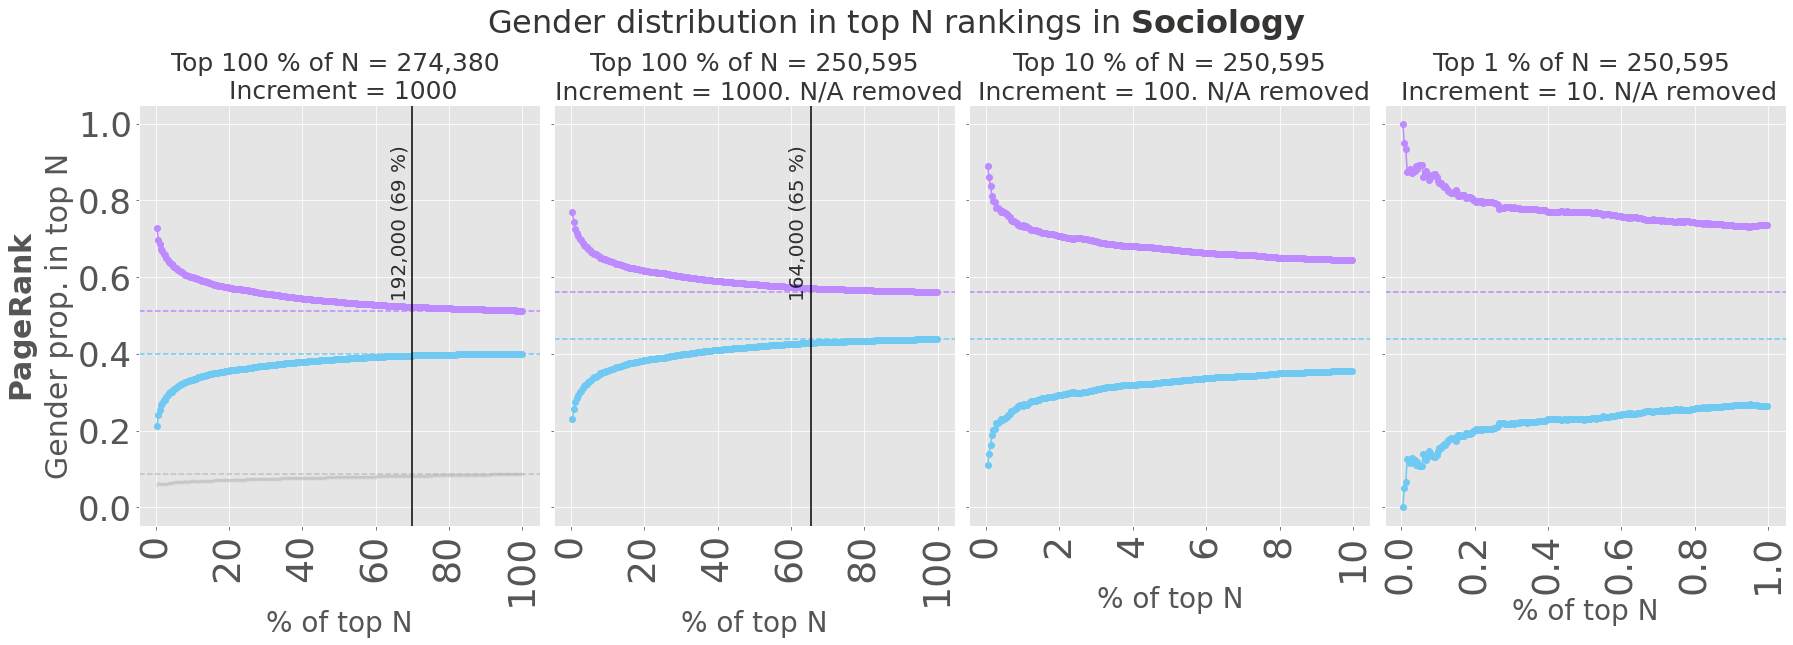

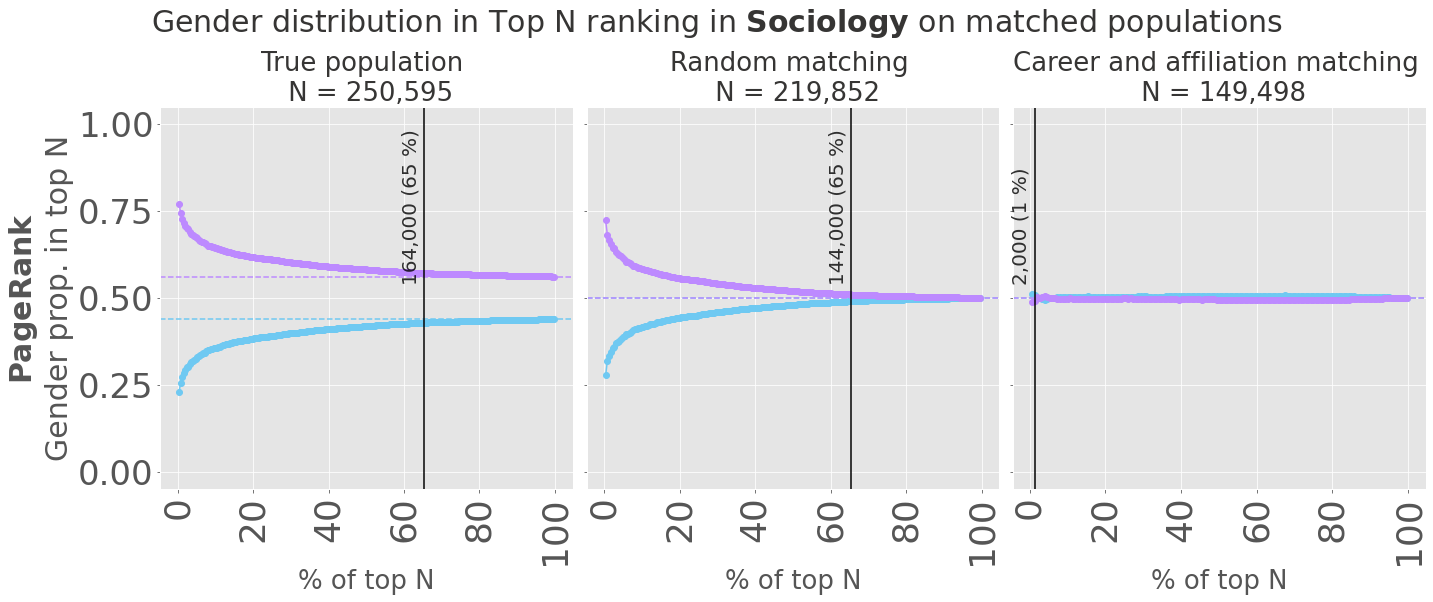

Median rank position of all authors: 125297.0
Median rank position of authors in random matching: 125849.5
Median rank position of authors in career and aff. matching: 123085.5


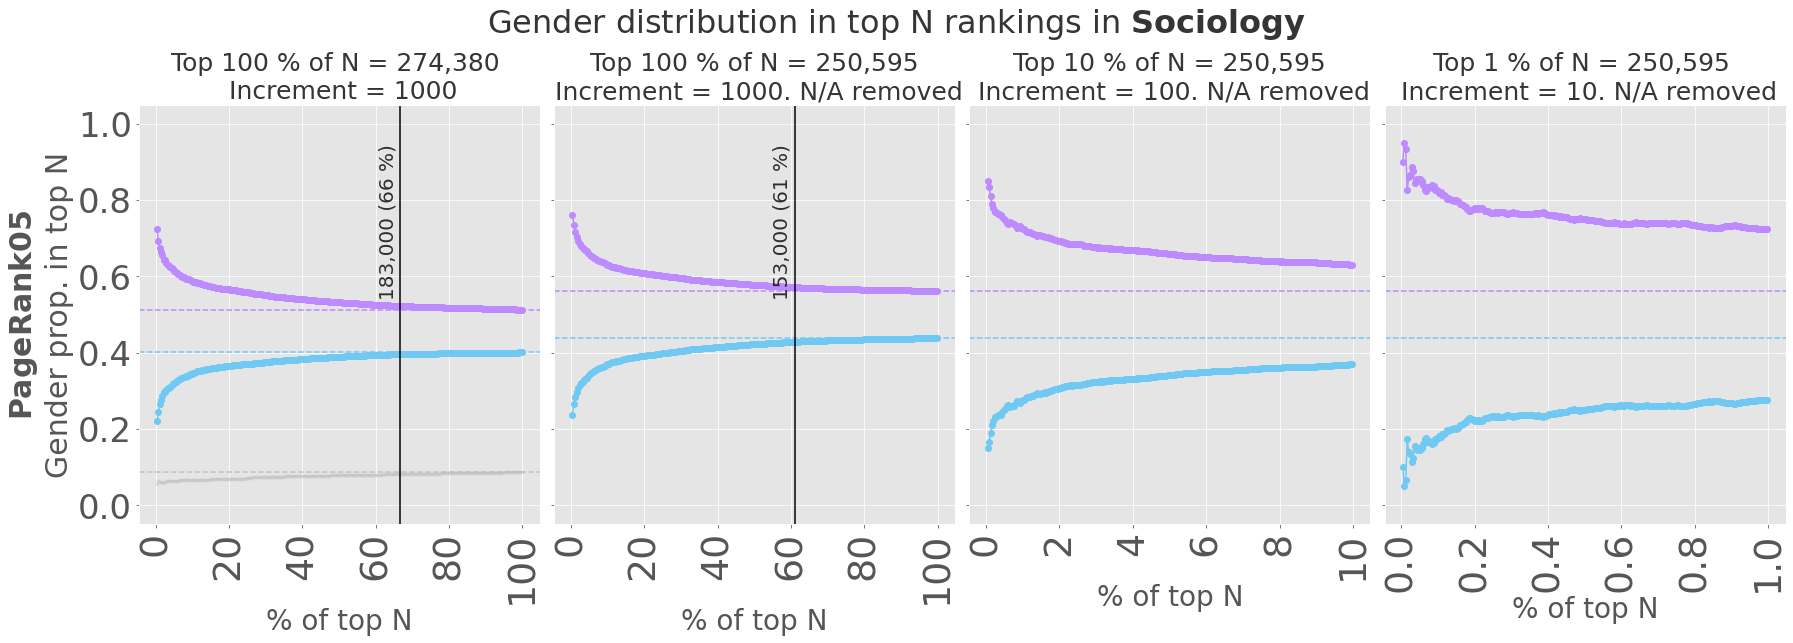

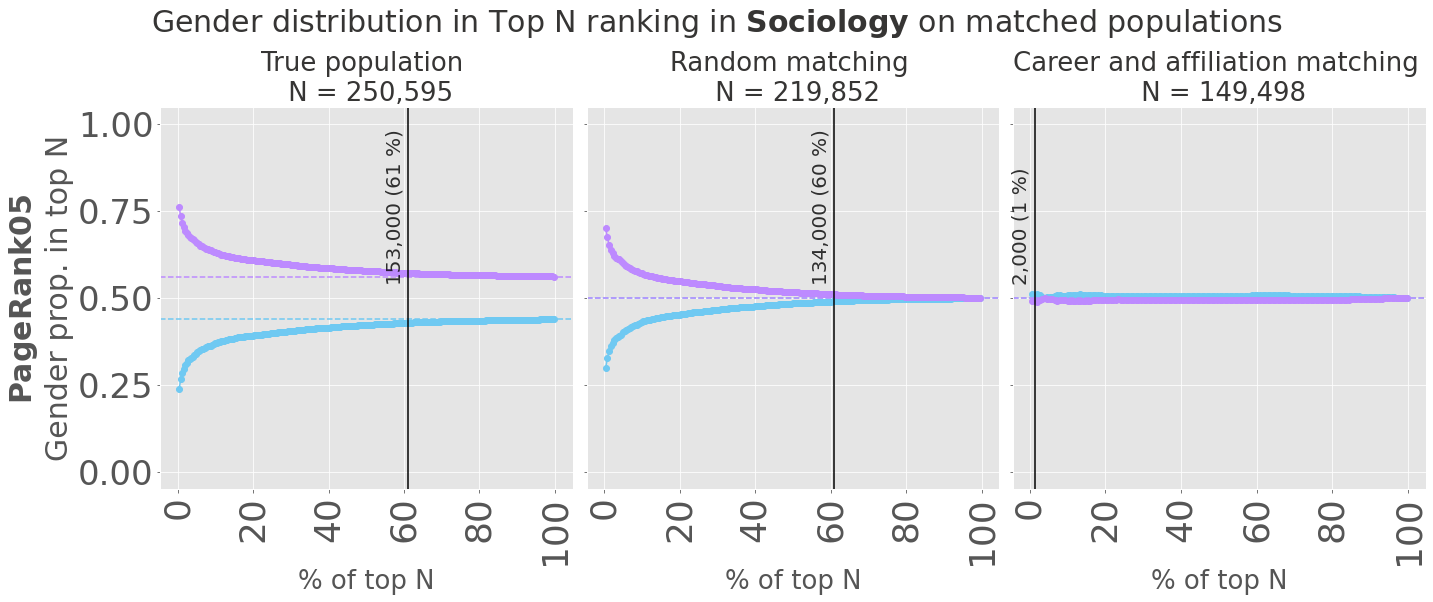

Median rank position of all authors: 125297.0
Median rank position of authors in random matching: 125771.0
Median rank position of authors in career and aff. matching: 118887.5


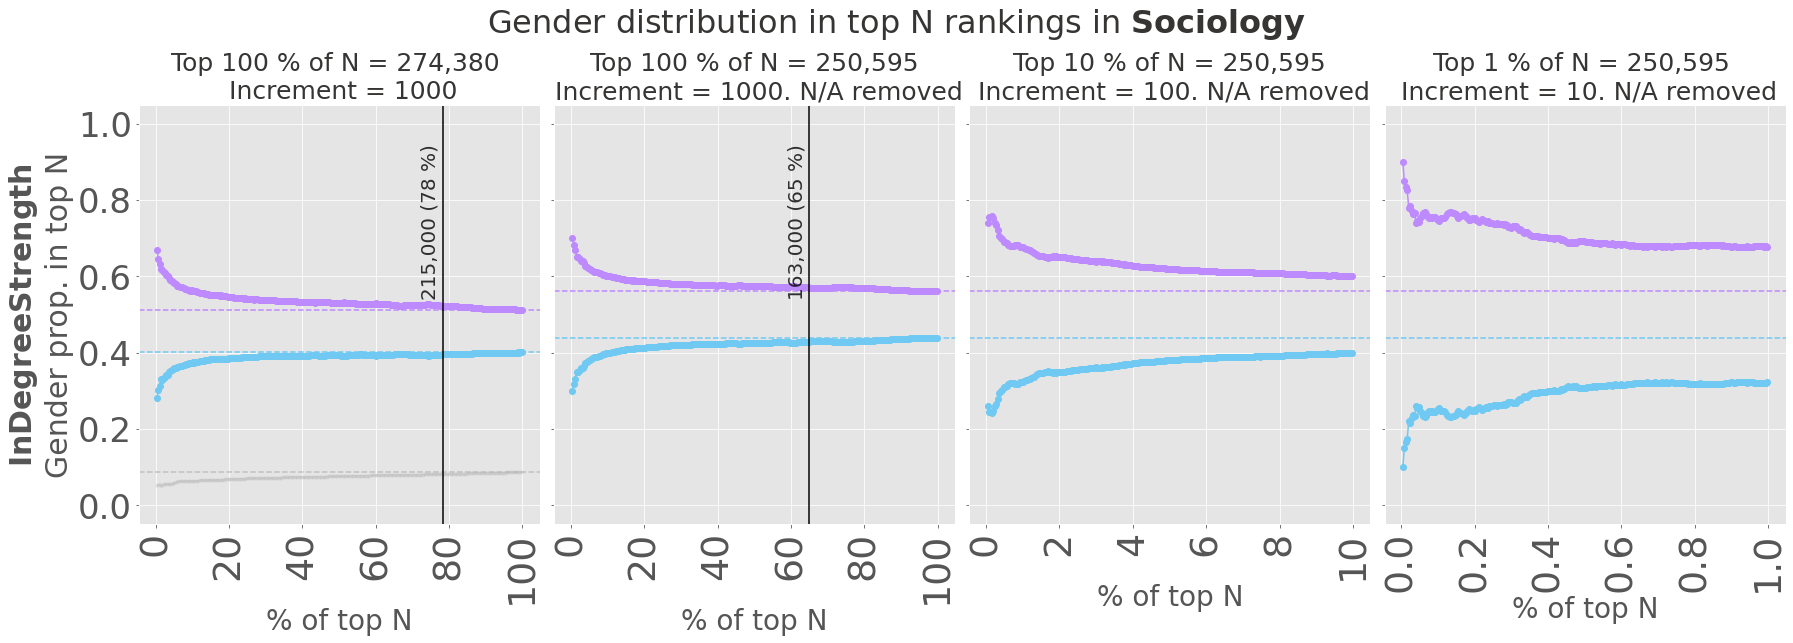

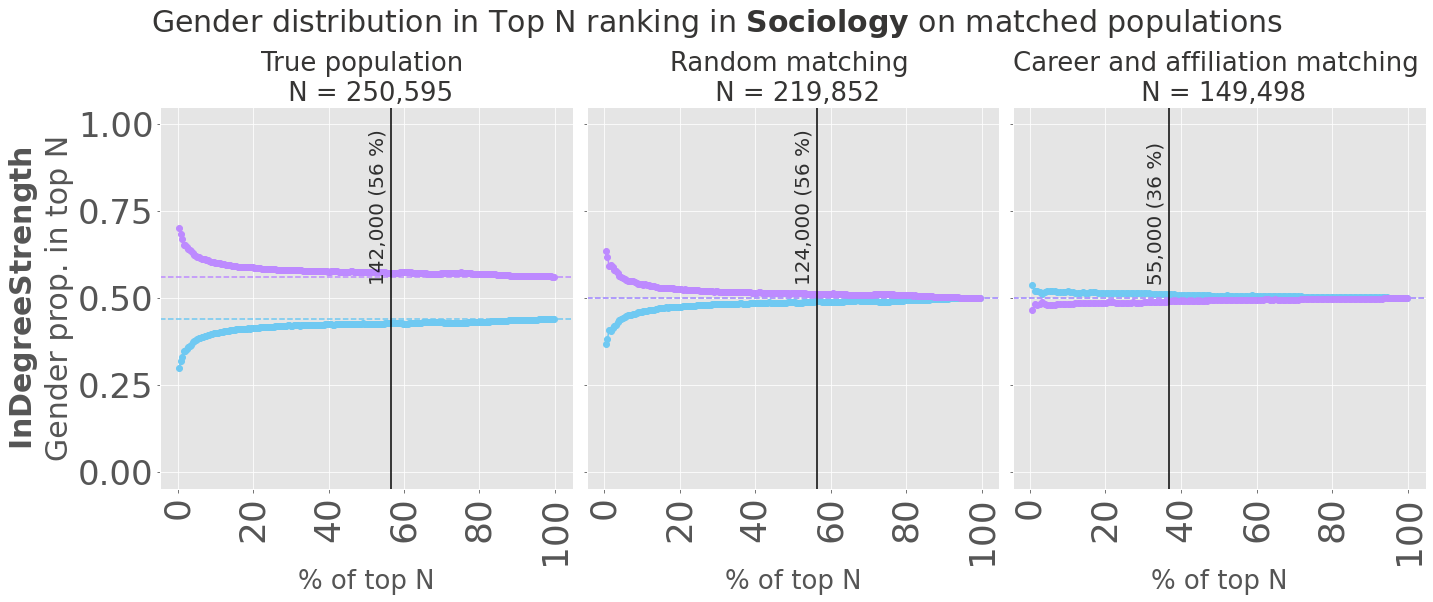

Median rank position of all authors: 125297.0
Median rank position of authors in random matching: 126893.5
Median rank position of authors in career and aff. matching: 114662.5


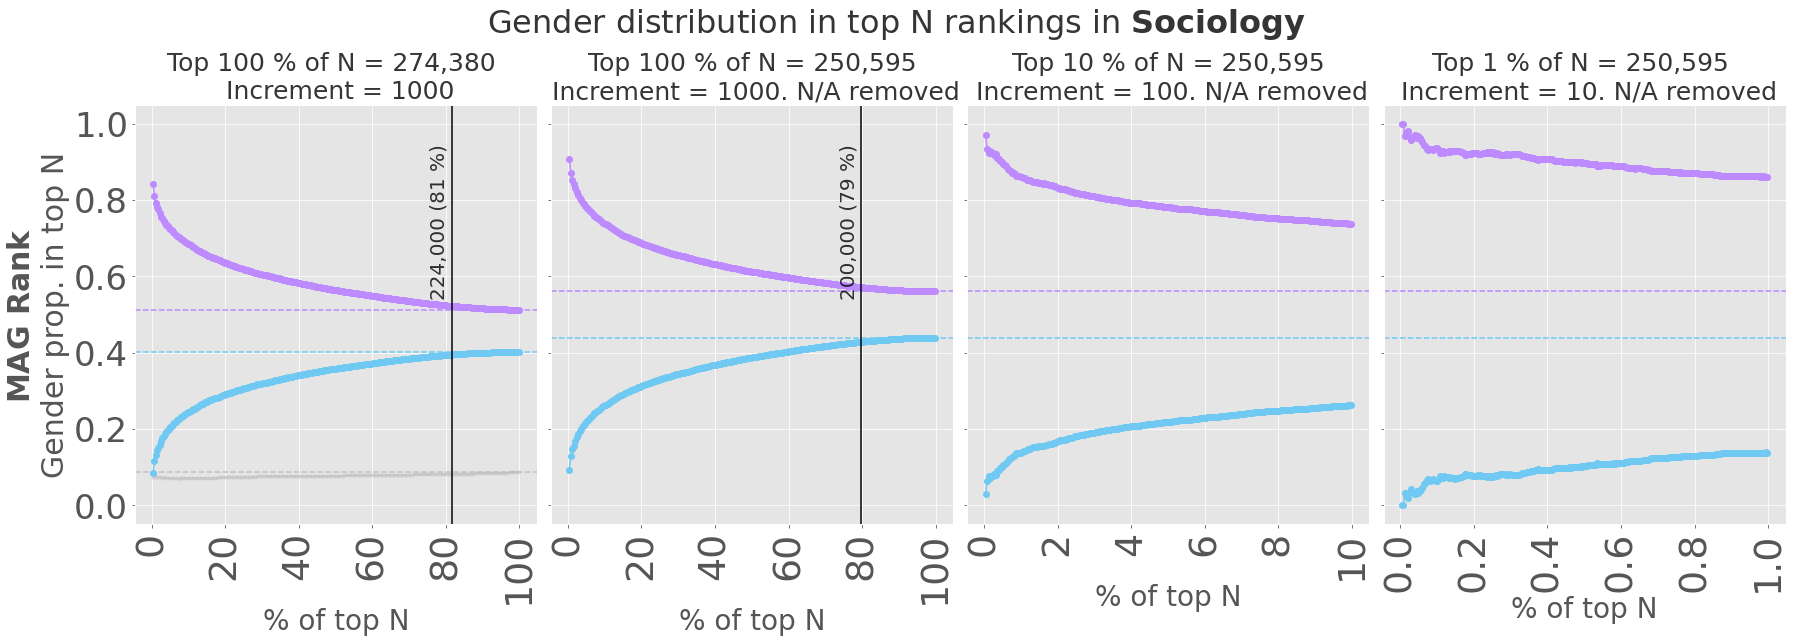

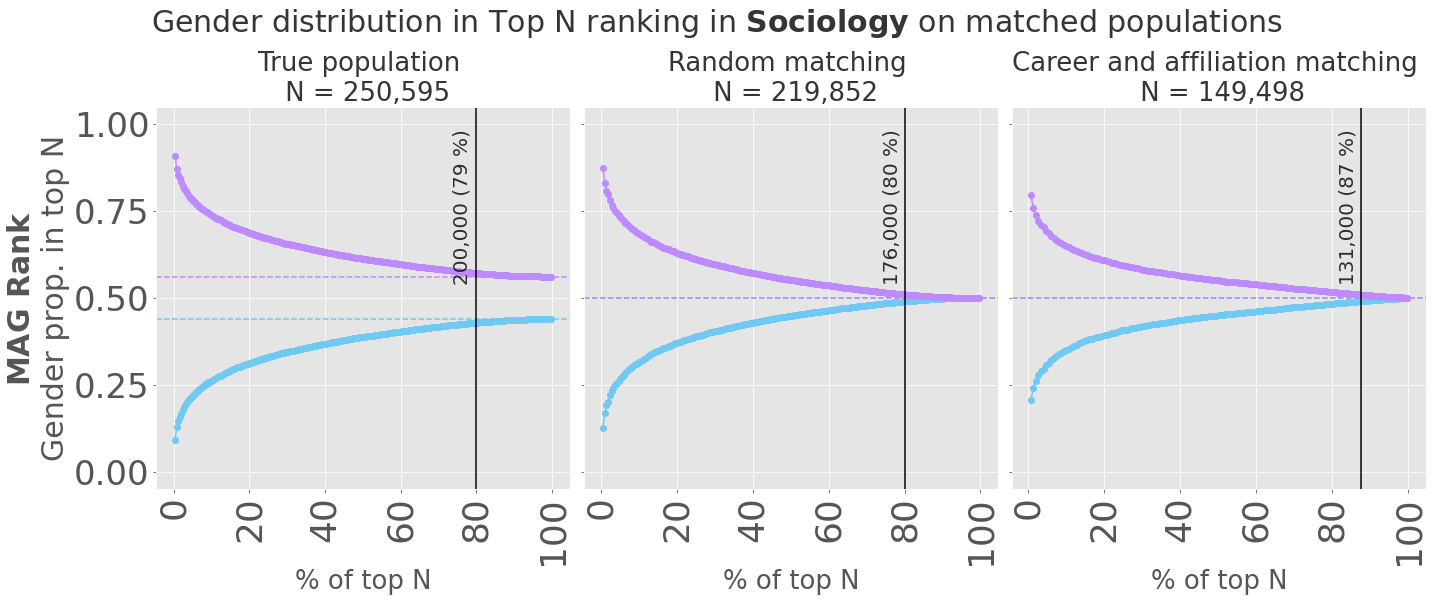

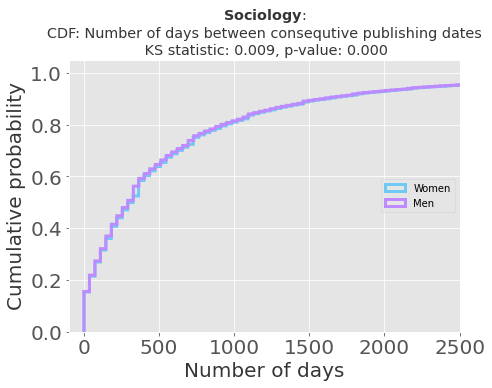

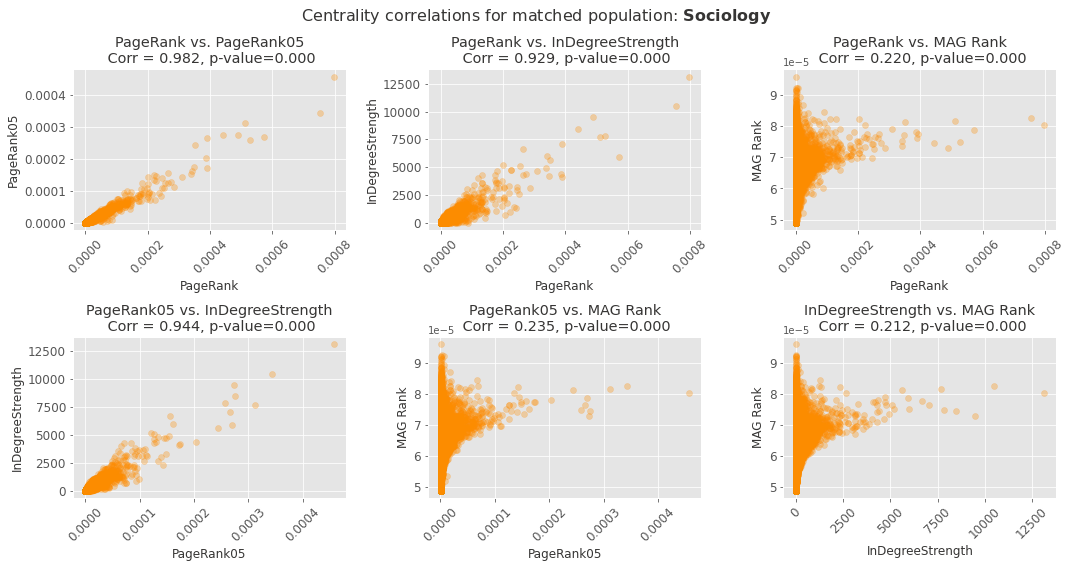

Visualizations stored in /home/laal/MAG//CentralityFairness/EVALUATIONS_PLOTS/
Finished analysis pipeline


In [6]:
results_df = analysis_pipeline(mag, 
                               fos_id=144024400, 
                               fos_name="Sociology", 
                               network_name="Sociology2020", 
                               root_folder = "/home/laal/MAG/", 
                               mindate='1800-01-01', 
                               maxdate='2020-12-31', 
                               overwrite=False,
                               random_seed=11, 
                               repeat_matching=False)

Finally we can evaluate the matching experiment results from `results_df`:    
* 'true' refers to the evaluation on the full ranking.  
* 'random' refers to the evaluation on authors selected in random matching.  
* 'matched' refers to the evaluation on authors selected in career and affiliation matching.  

In [7]:
results_df

,rND,rKL,rRD,equal_ex,centrality,type,iteration
0,0.099968,0.014652,1.639422e-01,1.061720,PageRank,true,11
1,0.103987,0.014647,1.673660e-01,1.060976,PageRank,random,11
2,0.011299,0.000094,5.840809e-04,0.985819,PageRank,matched,11
3,0.085823,0.011390,1.423363e-01,1.042026,PageRank05,true,11
4,0.088892,0.011169,1.451642e-01,1.041636,PageRank05,random,11
5,0.015956,0.000173,8.537669e-07,0.989247,PageRank05,matched,11
6,0.056810,0.004602,9.833630e-02,1.084239,InDegreeStrength,true,11
7,0.057529,0.004262,9.881078e-02,1.080708,InDegreeStrength,random,11
8,0.025596,0.000572,0.000000e+00,1.001685,InDegreeStrength,matched,11
9,0.216276,0.062379,3.213259e-01,0.997642,Rank,true,11


The entire pipeline on sociology takes app. 20 minutes on the infrastructure available during the thesis implementation. Other disciplines, however, take vastly more time. 

With time limitations in mind we have implemented the pipeline such that it will recognize required files (e.g. paper references and citations) and skip the steps to compute these in case they already exist.  

This is exemplified here by re-running the matching pipeline for sociology:

Paper references and citations available for Sociology
Network exists at /home/laal/MAG/DATA/NETWORKS/Sociology2020.txt. 
       Use overwrite to replace
The network has 19544848 edges
The network has 1309892 nodes
Gender distribution in WACN: 
 
 -1    769604
 1    303428
 0    236860
Name: Gender, dtype: int64 

Centrality scores exist at /home/laal/MAG/DATA/NETWORKS/Sociology2020Centrality.csv. 
        Use overwrite to replace
Genderized centrality CSV exists at /home/laal/MAG/DATA/NETWORKS/Sociology2020CentralityGendered.csv
        Use overwrite to replace

INITIATING MATCHING

Results of filtering:
  - Men with fewer than 2 papers:  162759
  - Women with fewer than 2 papers:  126934
  - Non-genderized with fewer than 2 papers:  61507
  - Men with more than 1 paper:  140669
  - Women with more than 1 paper:  109926
  - Non-genderized with more than 1 paper:  23785

Sampled 109926 men and 109926 women randomly. Total 219852 records
  -  Number of men after removing NaN-affiliation

100%|██████████| 87549/87549 [01:38<00:00, 888.03it/s] 


Found 74749 matches to 109926 females
Visualizing matching results
Median rank position of all authors: 125297.0
Median rank position of authors in random matching: 126014.5
Median rank position of authors in career and aff. matching: 124226.0


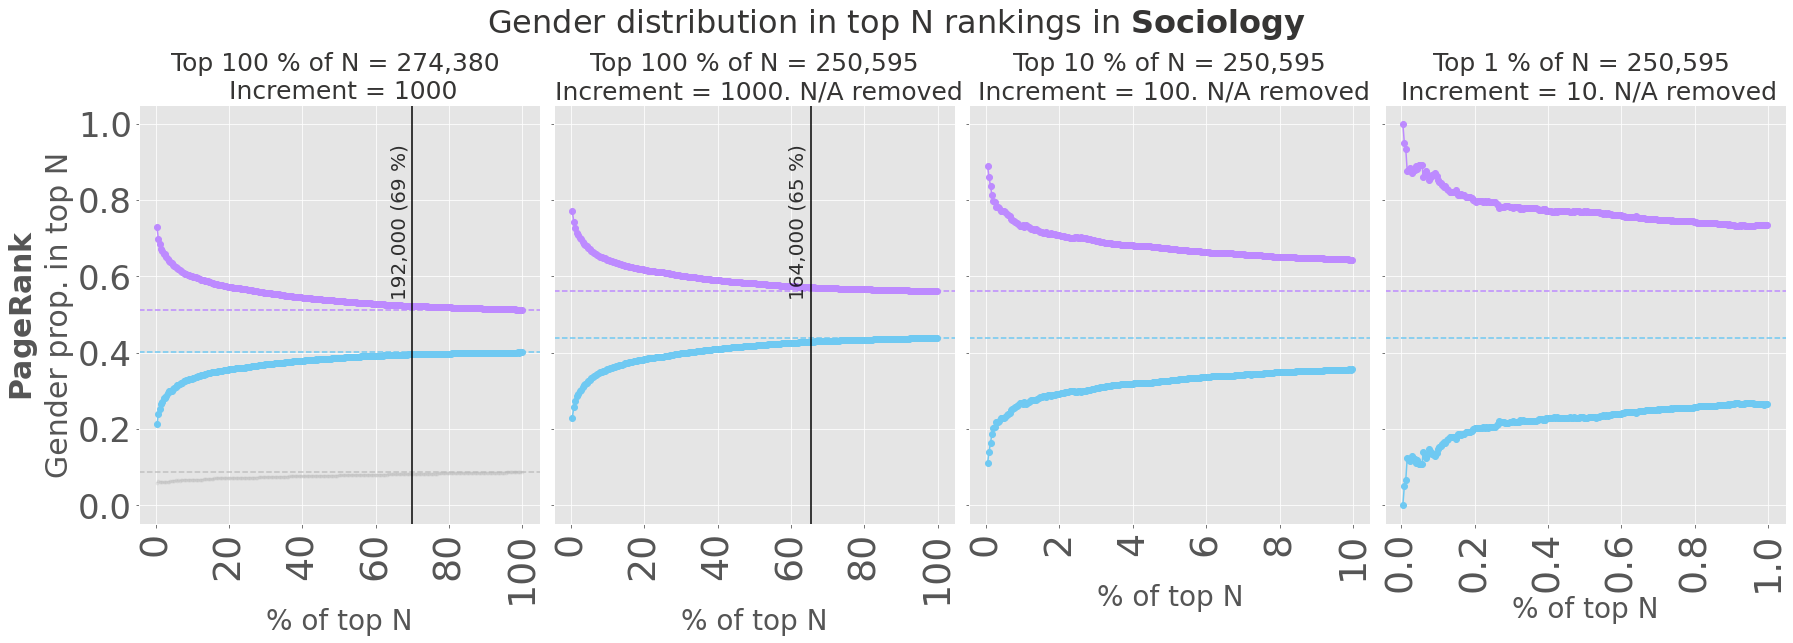

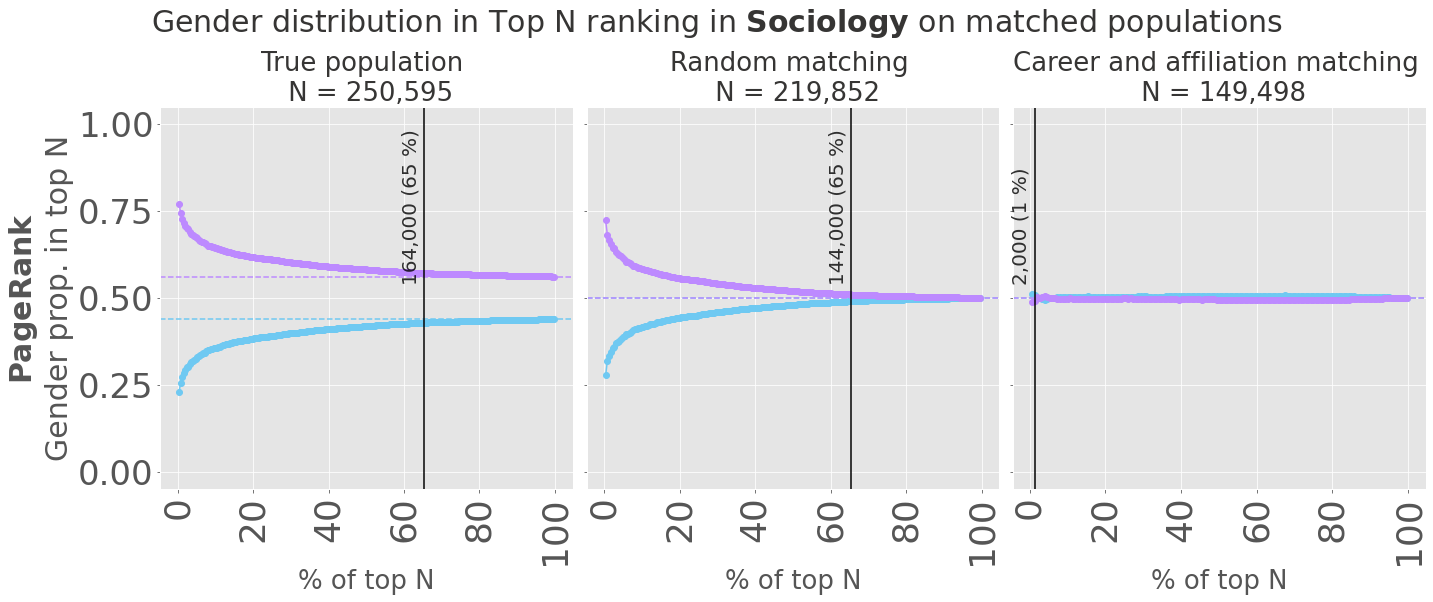

Median rank position of all authors: 125297.0
Median rank position of authors in random matching: 125849.5
Median rank position of authors in career and aff. matching: 123085.5


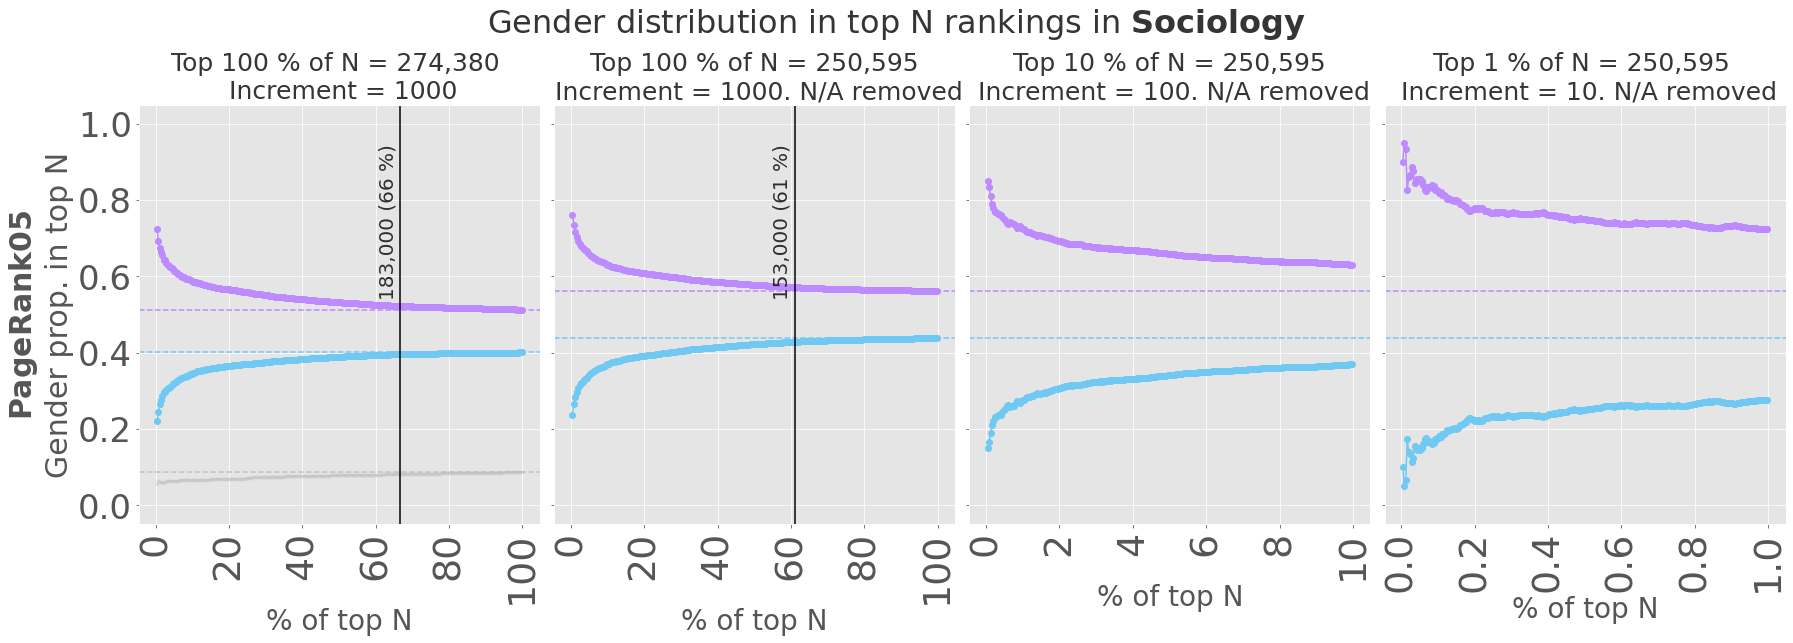

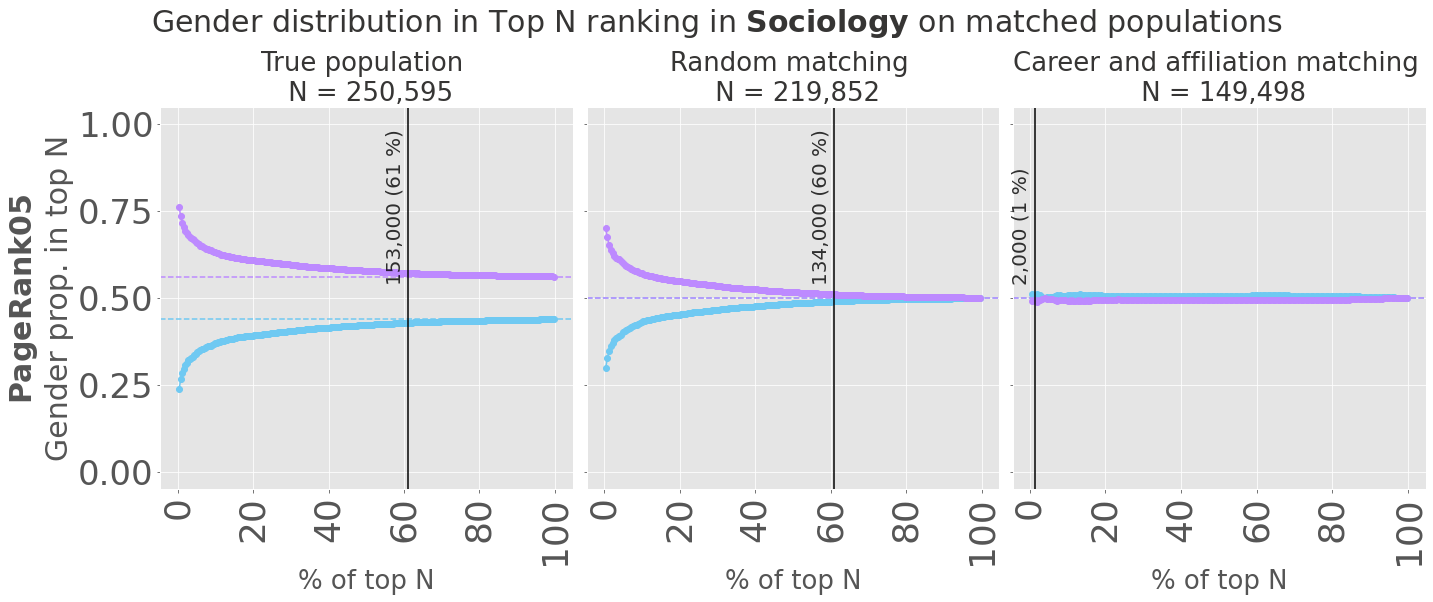

Median rank position of all authors: 125297.0
Median rank position of authors in random matching: 125771.0
Median rank position of authors in career and aff. matching: 118887.5


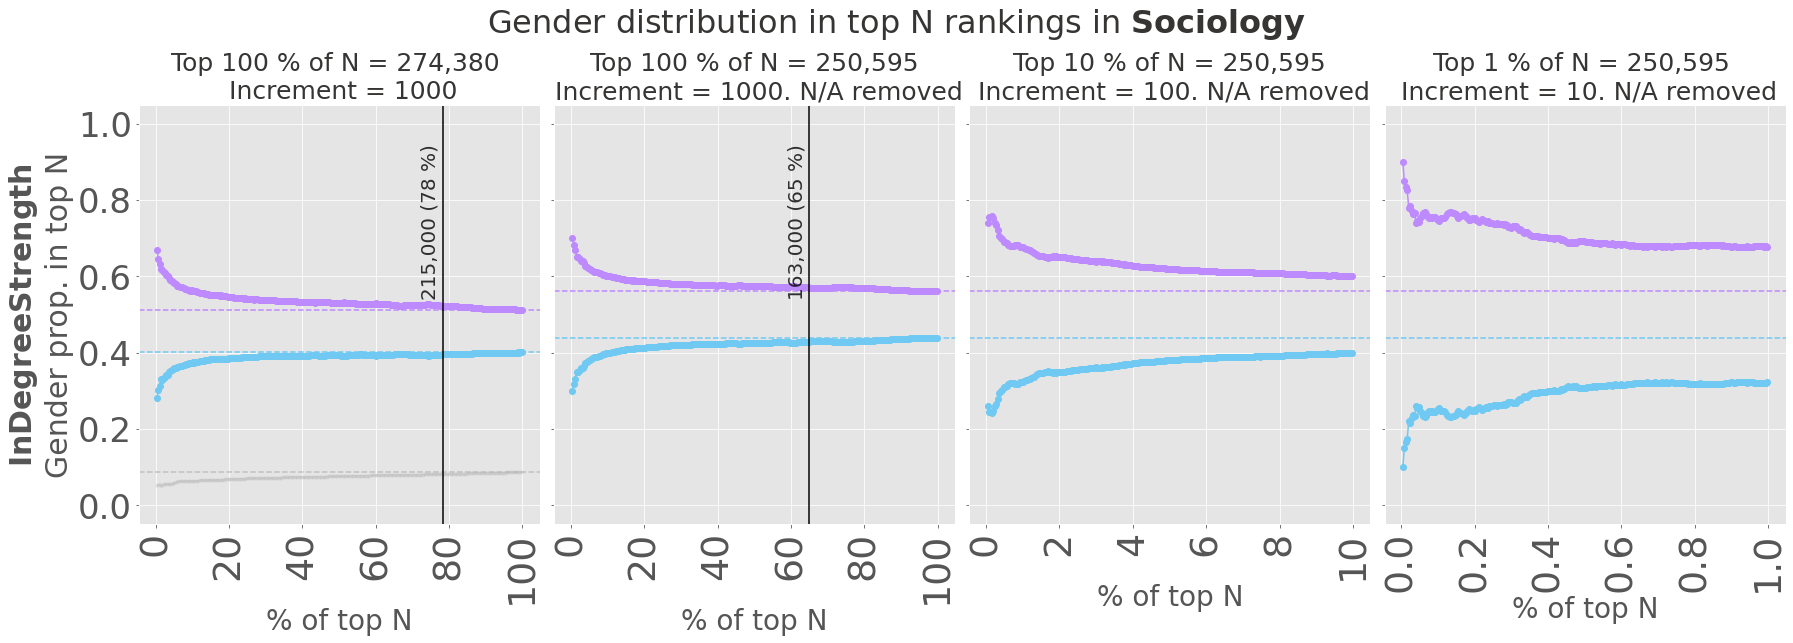

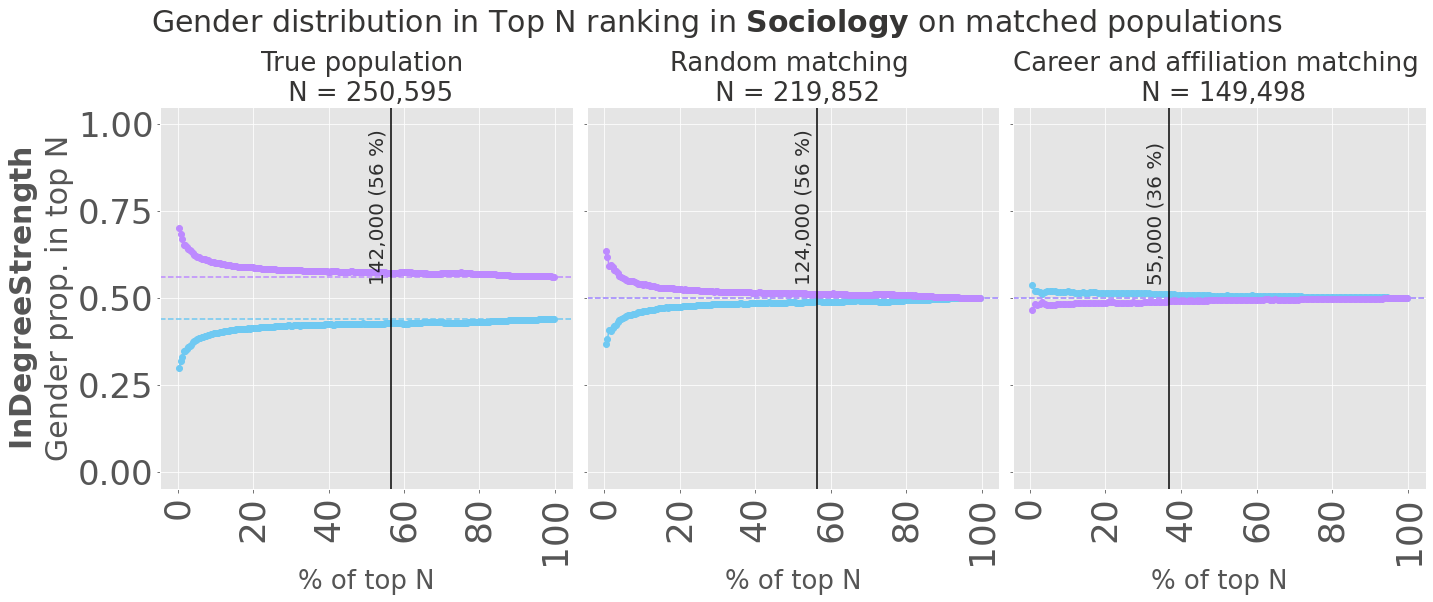

Median rank position of all authors: 125297.0
Median rank position of authors in random matching: 126893.5
Median rank position of authors in career and aff. matching: 114662.5


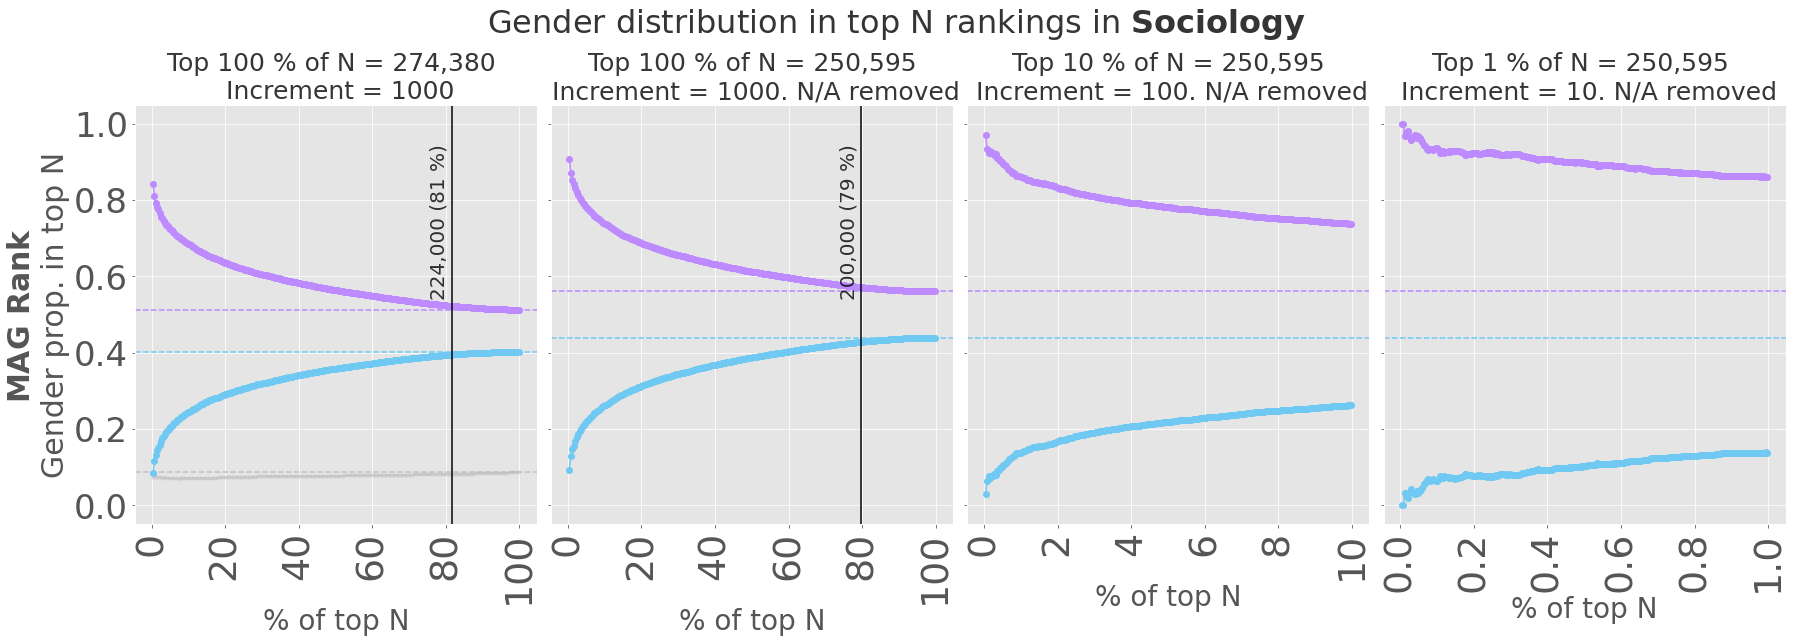

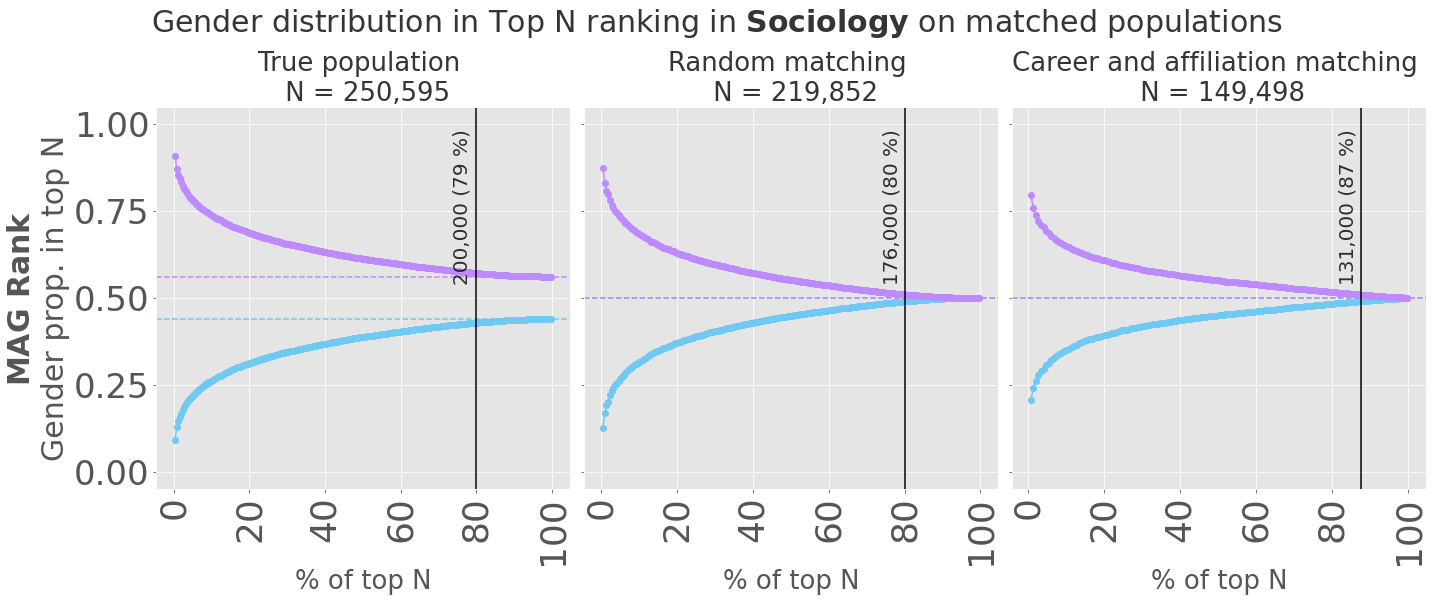

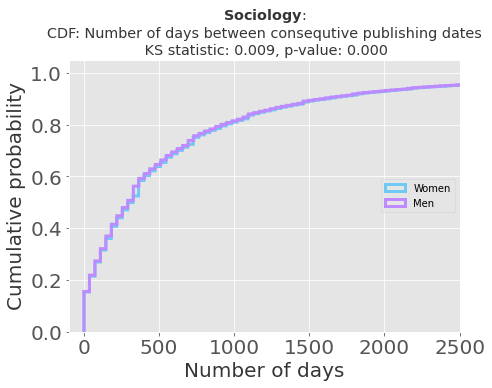

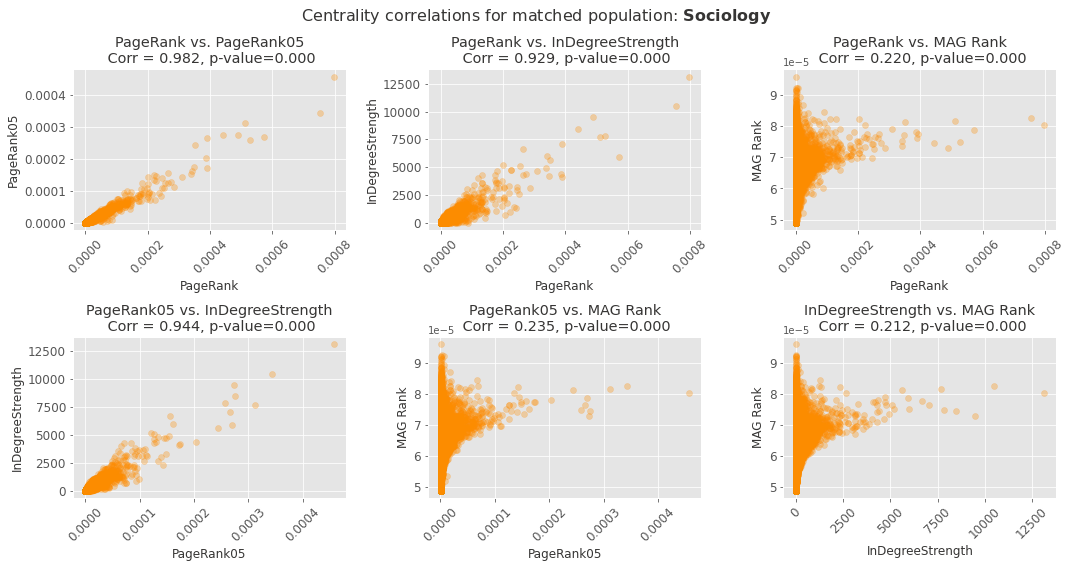

Visualizations stored in /home/laal/MAG//CentralityFairness/EVALUATIONS_PLOTS/
Finished analysis pipeline


In [8]:
results_df = analysis_pipeline(mag, 
                               fos_id=144024400, 
                               fos_name="Sociology", 
                               network_name="Sociology2020", 
                               root_folder = "/home/laal/MAG/", 
                               mindate='1800-01-01', 
                               maxdate='2020-12-31', 
                               overwrite=False,
                               random_seed=11, 
                               repeat_matching=False)